In [1]:
from distributed import Client

# Connect to cluster
client = Client()
client.dashboard_link

'http://127.0.0.1:8787/status'

In [2]:
import dask.dataframe as dd

# Read count data
counts = dd.read_parquet("councils-in-action-ds/rolling-30d/*")
counts = counts.persist()
counts

,council,ngram,session_datetime,count_,percent_of_total
npartitions=1326,,,,,
,object,object,"datetime64[ns, UTC]",float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [3]:
# Setup for plotting
import seaborn as sns
from cdp_data.plots import set_cdp_plotting_styles
from nltk.stem.snowball import SnowballStemmer

# Standard styling
set_cdp_plotting_styles()

# Stem words before counting
stemmer = SnowballStemmer("english")

def plot_ngrams(data, terms):
    stemmed_grams = [stemmer.stem(term) for term in terms]
    subset = data[data.ngram.isin(stemmed_grams)].persist()
    ax = sns.relplot(
        data=subset,
        x="session_datetime",
        y="percent_of_total",
        hue="ngram",
        style="ngram",
        col="council",
        col_wrap=3,
        kind="line",
    )
    ax.tick_params(axis="x", rotation=45)

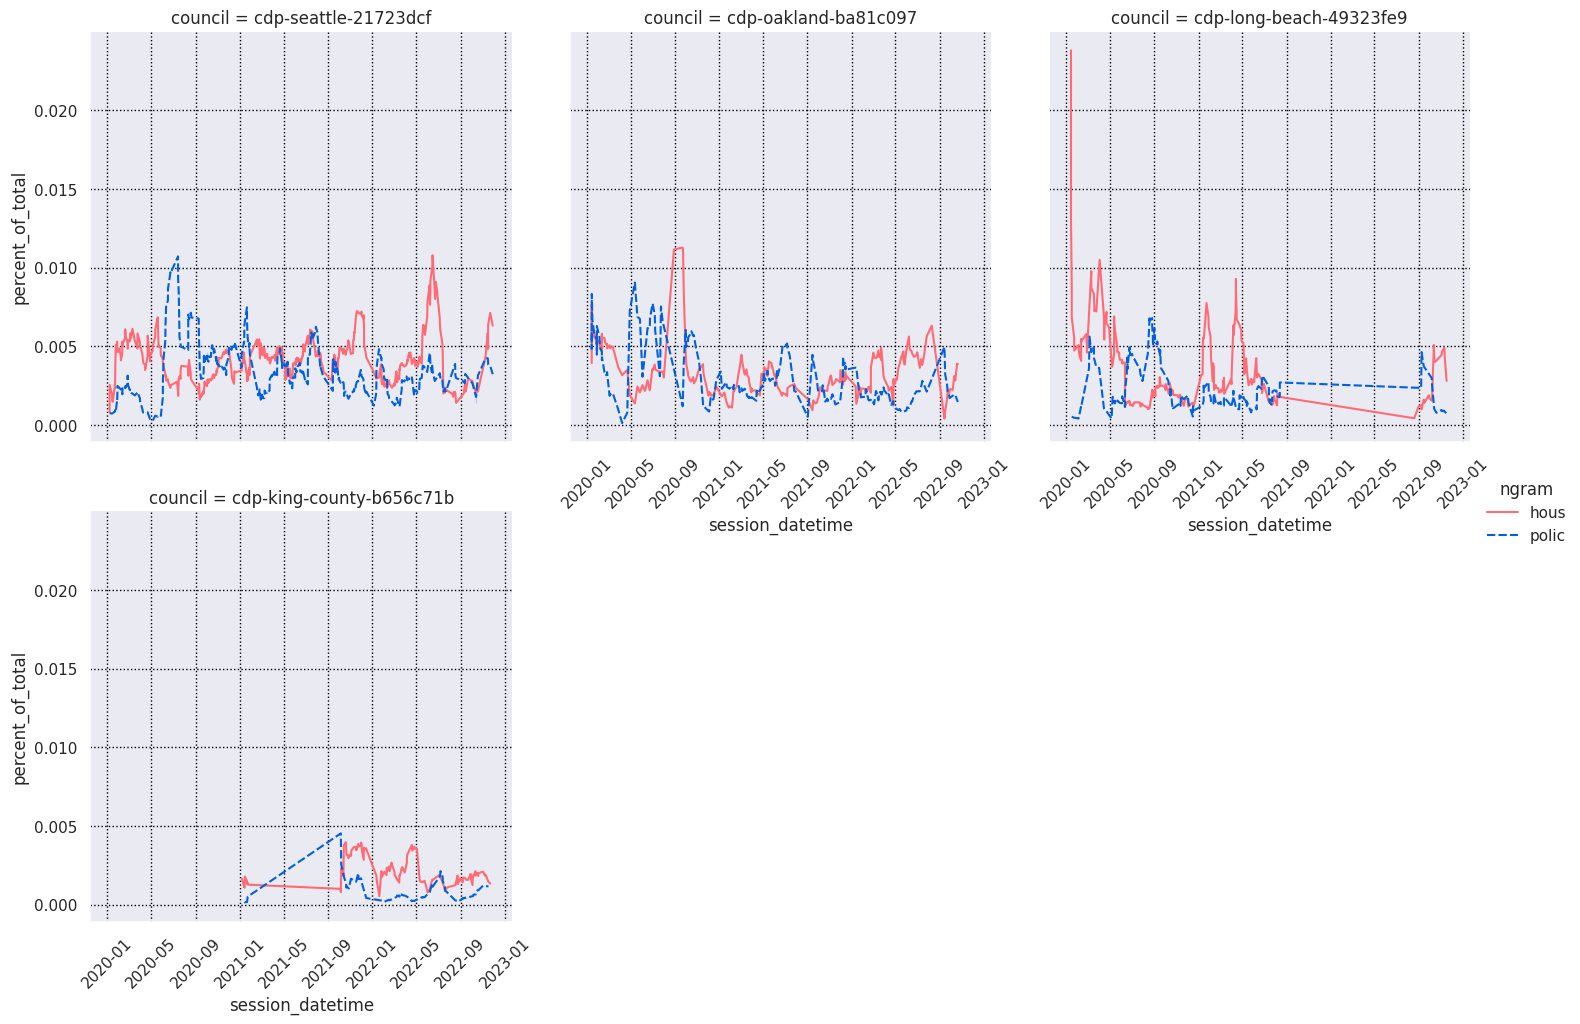

In [4]:
plot_ngrams(counts, ["police", "housing"])

In [5]:
# Take the average of all councils for a "baseline"
baseline = counts.groupby(["session_datetime", "ngram"]).mean().reset_index()
baseline["council"] = "baseline"
baseline = baseline.persist()

In [6]:
def plot_baseline_compare_terms(count_data, baseline_data, terms):
    stemmed_grams = [stemmer.stem(term) for term in terms]
    count_subset = count_data[count_data.ngram.isin(stemmed_grams)].compute()
    baseline_subset = baseline_data[baseline_data.ngram.isin(stemmed_grams)].compute()
    
    # Begin chart
    # council-1-ngram-1 |  council-2-ngram-1 |  council-3-ngram-1
    # council-1-ngram-2 |  council-2-ngram-2 |  council-3-ngram-2
    g = sns.relplot(
        count_subset,
        x="session_datetime",
        y="percent_of_total",
        col="council",
        row="ngram",
        hue="ngram",
        kind="line",
    )

    # Add average of all councils
    # Also rotate xticklabels
    for ax in g.axes.flatten():
        ax.plot(
            baseline_subset.session_datetime,
            baseline_subset.percent_of_total,
            color="black",
            linestyle="dotted",
            alpha=0.3,
        )
        ax.tick_params(axis="x", rotation=30)

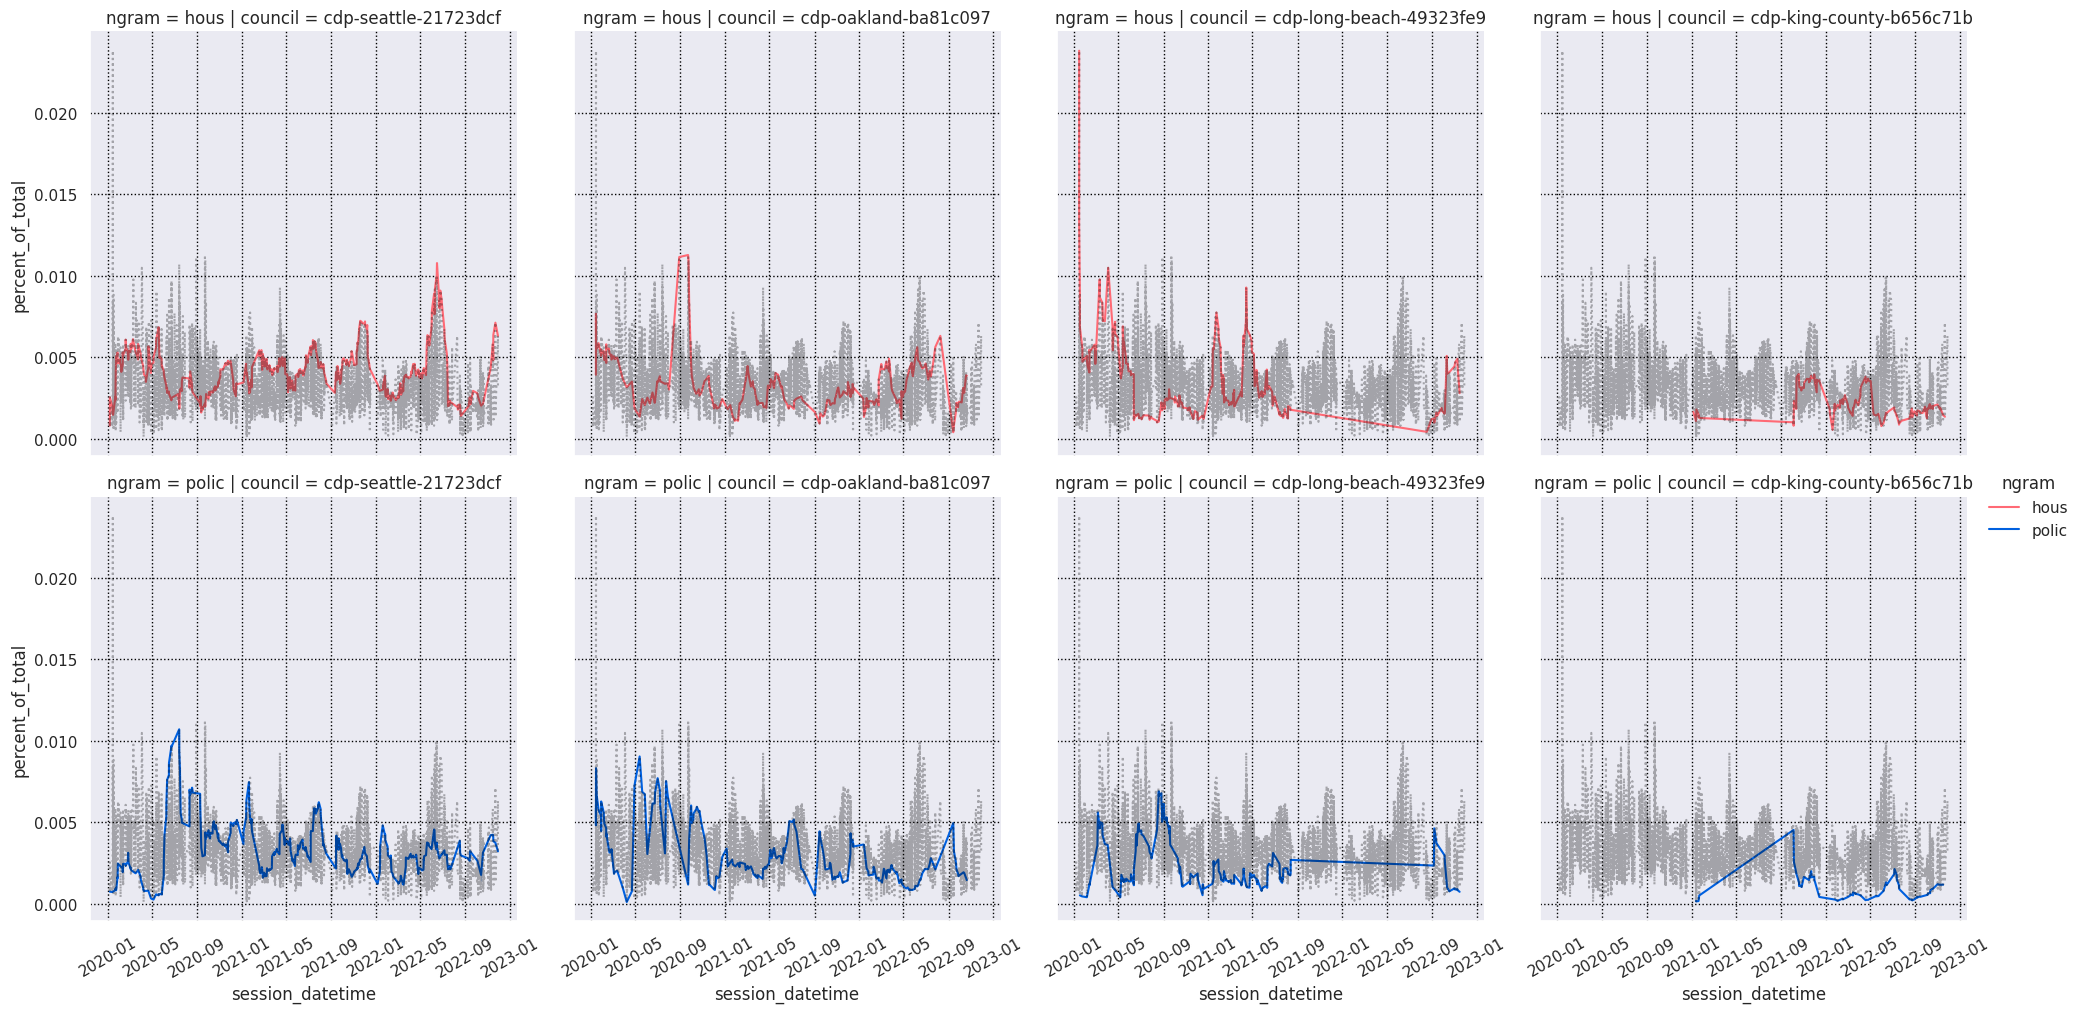

In [7]:
plot_baseline_compare_terms(counts, baseline, ["police", "housing"])